# Image Search Engine with CLIP Embeddings

![CLIP Architecture](https://github.com/openai/CLIP/raw/main/CLIP.png)

## Dataset Setup


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Dataset size: 10000
Number of classes: 200
Class names (first 10): ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']
Image shape: torch.Size([3, 224, 224])


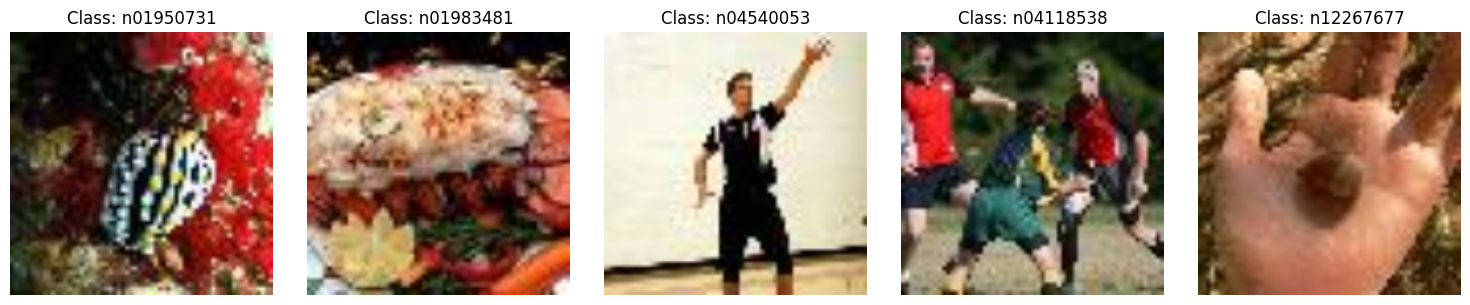

In [1]:
# Install tinyimagenet package
!pip install tinyimagenet

# Import necessary libraries
import torch
import torchvision.transforms as transforms
from tinyimagenet import TinyImageNet
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

# Load the validation dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load validation dataset
val_dataset = TinyImageNet(root='./data', split='val', transform=transform)

# Print dataset information
print(f"Dataset size: {len(val_dataset)}")
print(f"Number of classes: {len(val_dataset.classes)}")
print(f"Class names (first 10): {val_dataset.classes[:10]}")
print(f"Image shape: {val_dataset[0][0].shape}")

# Display 5 sample images with their class information
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
random_indices = random.sample(range(len(val_dataset)), 5)

for i, idx in enumerate(random_indices):
    image, label = val_dataset[idx]
    class_name = val_dataset.classes[label]

    # Convert tensor to numpy and transpose for plotting
    img_np = image.permute(1, 2, 0).numpy()

    axes[i].imshow(img_np)
    axes[i].set_title(f"Class: {class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Import Libraries and Configuration

In [2]:
# TODO: Import all necessary libraries
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import os

# TODO: Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# TODO: Load pre-trained CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
print(f"Loading CLIP model and processor ({model_name})…")
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

# TODO: Move model to device
model.to(device)

# TODO: Print model information
print(model)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cpu
Loading CLIP model and processor (openai/clip-vit-base-patch32)…
CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_feature

In [4]:
print(model.config)

CLIPConfig {
  "architectures": [
    "CLIPModel"
  ],
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 512,
  "text_config": {
    "attention_dropout": 0.0,
    "bos_token_id": 0,
    "dropout": 0.0,
    "eos_token_id": 2,
    "hidden_act": "quick_gelu",
    "hidden_size": 512,
    "initializer_factor": 1.0,
    "initializer_range": 0.02,
    "intermediate_size": 2048,
    "layer_norm_eps": 1e-05,
    "max_position_embeddings": 77,
    "model_type": "clip_text_model",
    "num_attention_heads": 8,
    "num_hidden_layers": 12,
    "projection_dim": 512,
    "torch_dtype": "float32",
    "vocab_size": 49408
  },
  "torch_dtype": "float32",
  "transformers_version": "4.53.2",
  "vision_config": {
    "attention_dropout": 0.0,
    "dropout": 0.0,
    "hidden_act": "quick_gelu",
    "hidden_size": 768,
    "image_size": 224,
    "initializer_factor": 1.0,
    "initializer_range": 0.02,
    "intermediate_size": 3072,
    "layer_nor

## Feature/Embeddings Extraction using CLIP from Dataset

In [5]:
# define a custom dataset class to later create a dataloader for going through images
class ImageNetValDataset(Dataset):
    def __init__(self, root_dir = "./data/tiny-imagenet-200"):
        size = processor.feature_extractor.size["shortest_edge"]     
        mean = processor.feature_extractor.image_mean
        std  = processor.feature_extractor.image_std
        # Build a transform that matches what CLIP expects
        self.transform = T.Compose([
            T.Resize(size),       # 224
            T.ToTensor(),      # converts to [0,1], shape (3,H,W)
            T.Normalize(mean, std)
        ])

        # create dictionary for id to label matching
        words_path =  os.path.join(root_dir, "words.txt")
        id2name = {}
        with open(words_path, "r") as f:
            for line in f:
                id, name = line.strip().split("\t")
                id2name[id] = name.split(",")[0]
        self.id2name = id2name

        # create dictionary for id to index matching
        val_dir = os.path.join(root_dir, "val")
        classes = [
            d for d in os.listdir(val_dir)
            if os.path.isdir(os.path.join(val_dir, d))
        ]
        classes.sort()
        self.classes = classes
        self.class_to_idx = {id: i for i, id in enumerate(classes)}

        # collect (path, label_name) for every image
        exts = (".jpg", ".jpeg", ".png", ".JPEG")
        self.samples = []
        for id in classes:
            images_dir = os.path.join(val_dir, id, "images")
            for fname in sorted(os.listdir(images_dir)):
                if fname.lower().endswith(exts):
                    img_path = os.path.join(images_dir, fname)
                    label    = self.class_to_idx[id]
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load PIL image
        # Apply transforms to get (3,224,224)
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        pixel_values = self.transform(img)
        return pixel_values, label

In [6]:
dataset = ImageNetValDataset(root_dir="./data/tiny-imagenet-200")
val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\clip\processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [7]:
def extract_image_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for pixel_values, labels in tqdm(dataloader, desc= "Extracting embeddings"):
            pixel_values = pixel_values.to(device)

            # process batch through CLIP
            image_features = model.get_image_features(pixel_values)

            # Normalize embeddings for cosine similarity
            image_features = F.normalize(image_features, dim=-1)

            all_embeddings.append(image_features.cpu())
            
    # Concatenate all embeddings
    return torch.cat(all_embeddings, dim=0)

In [ ]:
# Extract embeddings from the validation dataset
embeddings = extract_image_embeddings(model, val_loader, device)
print(f"\nTotal embeddings shape: {embeddings.shape}")

# save embeddings for efficient searching
os.makedirs("embeddings", exist_ok=True)
save_path = "embeddings/val_image_embeddings.pt"
torch.save(embeddings, save_path)
print(f"Saved normalized embeddings to '{save_path}'")

In [9]:
# load the embeddings from folder if already extracted
save_path = "embeddings/val_image_embeddings.pt"
embeddings = torch.load(save_path)

## Zero-Shot Classification Evaluation

In [10]:
# create text prompts
prompts = [f"a picture of a {dataset.id2name[id]}" for id in dataset.classes]
print("FIrst 10 Prompts: ")
for i in prompts[:10]:
    print(i)

# extract text embeddings for prompt
text_inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_feats = model.get_text_features(**text_inputs)    
text_feats = F.normalize(text_feats, dim=-1).cpu()      

# loop over val images to get labels
all_labels    = []
with torch.no_grad():
    for _, ids in tqdm(val_loader):
        all_labels.extend(ids.tolist())

labels = torch.tensor(all_labels)  # (N_samples,)
print(embeddings.shape, labels.shape)

FIrst 10 Prompts: 
a picture of a goldfish
a picture of a European fire salamander
a picture of a bullfrog
a picture of a tailed frog
a picture of a American alligator
a picture of a boa constrictor
a picture of a trilobite
a picture of a scorpion
a picture of a black widow
a picture of a tarantula


100%|██████████| 313/313 [00:30<00:00, 10.27it/s]

torch.Size([10000, 512]) torch.Size([10000])


In [11]:
# Compute similarities and predictions
sims = embeddings @ text_feats.T

# accuracy metrics
def compute_topk(acc_sims, target, topk=(1,3, 5, 10)):
    maxk = max(topk)
    _, pred = acc_sims.topk(maxk, dim=1, largest=True, sorted=True)  # (N, maxk)
    pred = pred.t()                                                   # (maxk, N)
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = {}
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res[f"top{k}"] = (correct_k / target.size(0)).item() * 100.0
    return res

acc = compute_topk(sims, labels)
print(f"0_shot TinyImageNet accuracy: \n Top‐1: {acc['top1']:.2f}% \n Top‐3: {acc['top3']:.2f}% "
      f"\n Top‐5: {acc['top5']:.2f}% \n Top‐10: {acc['top10']:.2f}%")

0_shot TinyImageNet accuracy: 
 Top‐1: 61.82% 
 Top‐3: 79.13% 
 Top‐5: 83.96% 
 Top‐10: 89.61%


## Image Search Engine Implementation

In [12]:
# TODO: Implement text-to-image search

# TODO: Implement image-to-image search

# TODO: Create visualization function

def text_to_image_search(prompt, processor, model, image_embeddings, image_paths, device='cpu', top_k=5):
    # Encode text
    inputs = processor(text=prompt, return_tensors='pt', padding=True).to(device)
    with torch.no_grad():
        text_feats = model.get_text_features(**inputs)
    text_feats = F.normalize(text_feats, dim=-1).cpu()  # (P, D)

    # Compute cosine similarity
    sims = text_feats @ image_embeddings.T             # (P, N)
    top = torch.topk(sims, top_k)
    idxs = top.indices[0]
    scores = top.values[0]
    paths = [image_paths[j] for j in idxs]
    return list(zip(paths, scores))

def image_to_image_search(query_image_path, processor, model, image_embeddings, image_paths, device='cpu', top_k=5):
    # Load and encode query image
    img = Image.open(query_image_path).convert('RGB')
    inputs = processor(images=img, return_tensors='pt').to(device)
    with torch.no_grad():
        img_feats = model.get_image_features(**inputs)
    img_feats = F.normalize(img_feats, dim=-1).cpu().squeeze(0)  # (D,)

    # Compute cosine similarity
    sims = img_feats @ image_embeddings.T  # (N_samples,)
    top = torch.topk(sims, top_k)
    idxs = top.indices
    scores = top.values
    paths = [image_paths[j] for j in idxs]
    return list(zip(paths, scores))

def visualize_search_results(results, prompt, cols=5, figsize=(15, 5)):
    n = len(results)
    cols = min(cols, n)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, (path, score) in enumerate(results):
        ax = plt.subplot(rows, cols, i + 1)
        img = Image.open(path[0]).convert('RGB')
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"score: {score:.2f}")
    
    plt.suptitle(f"Prompt: {prompt}")
    plt.tight_layout()
    plt.show()

## Testing with Custom Queries

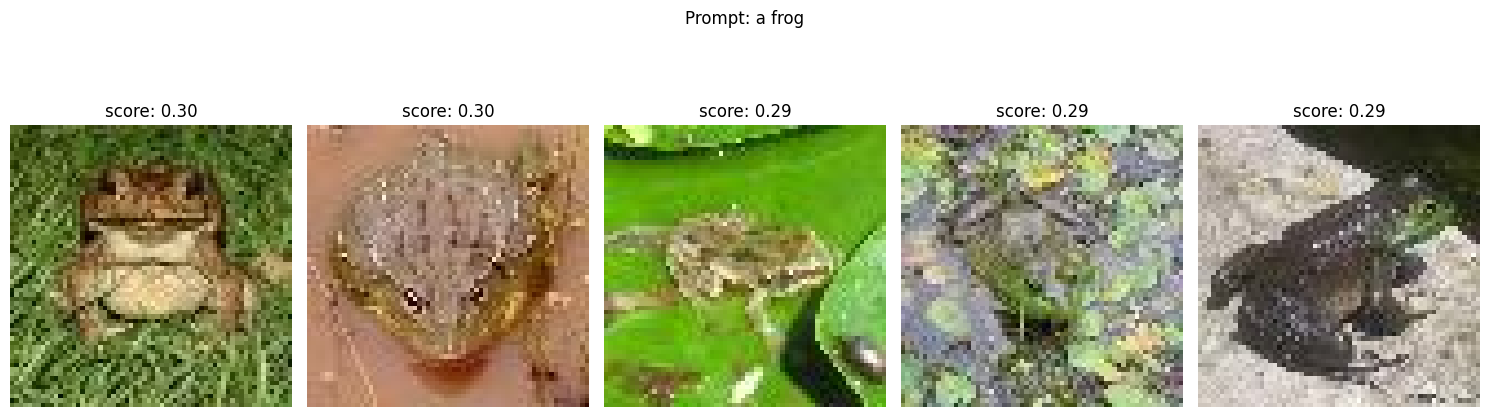

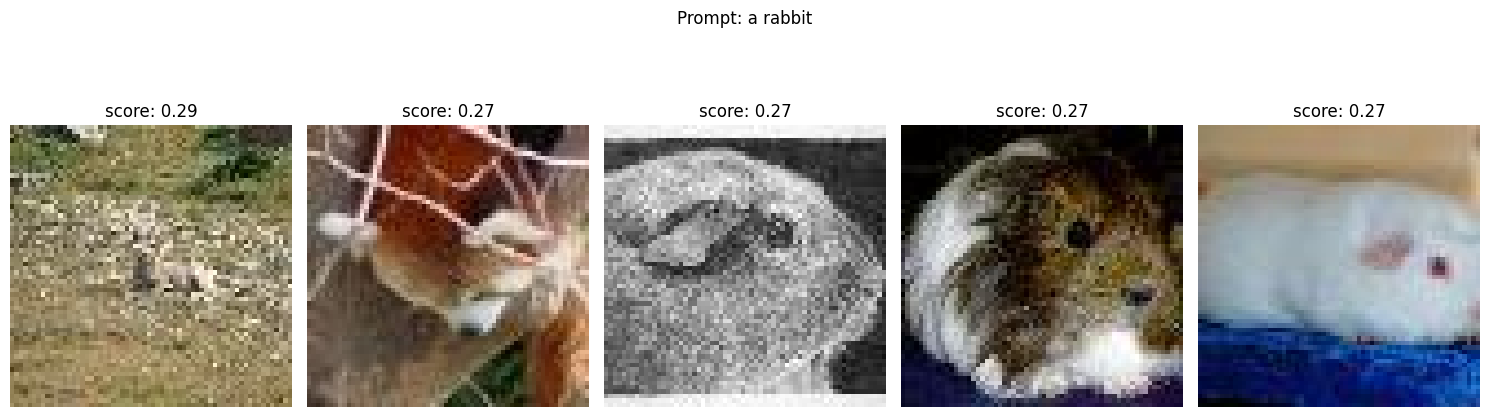

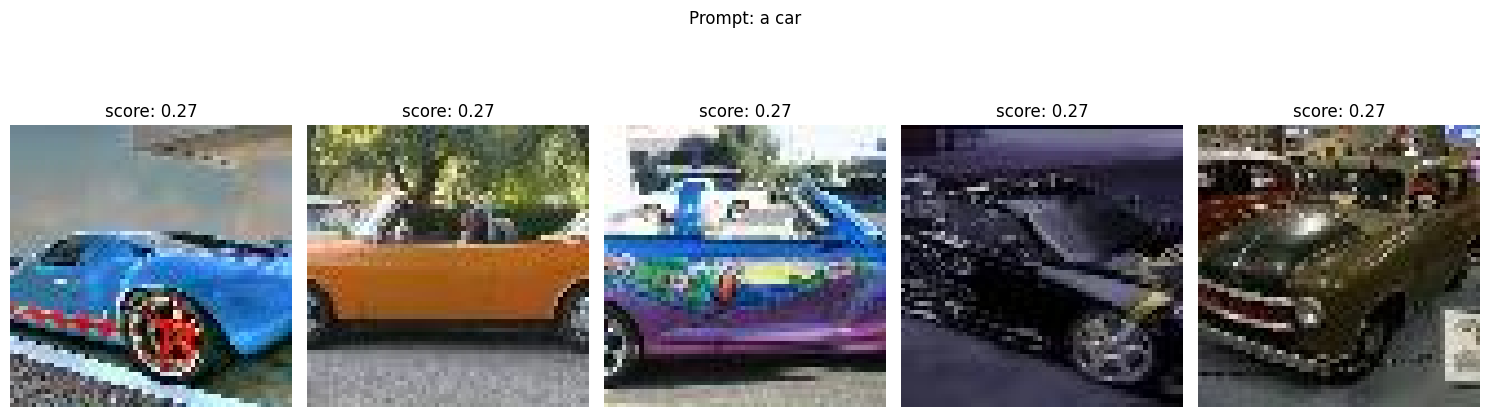

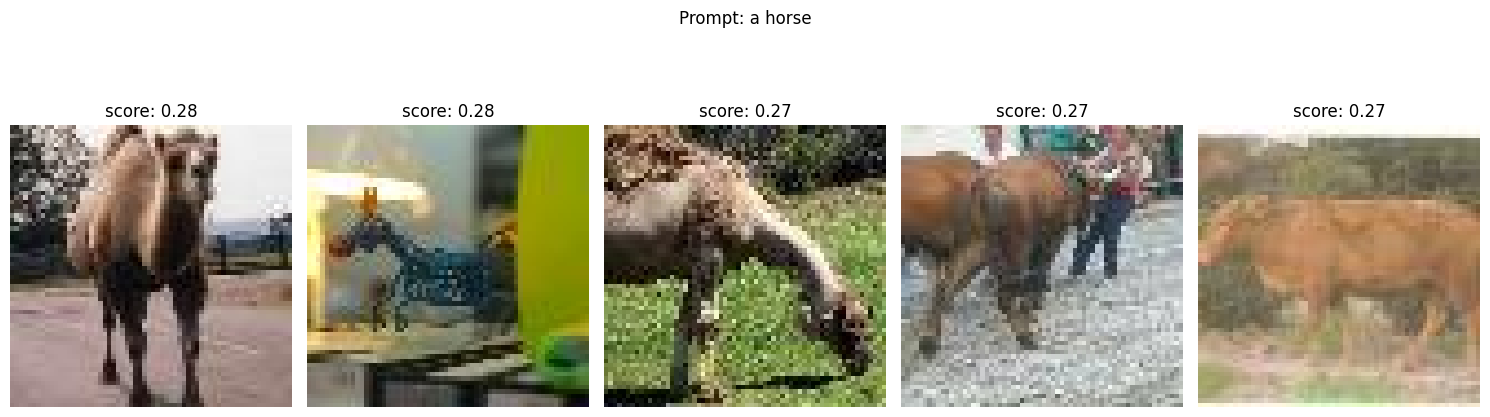

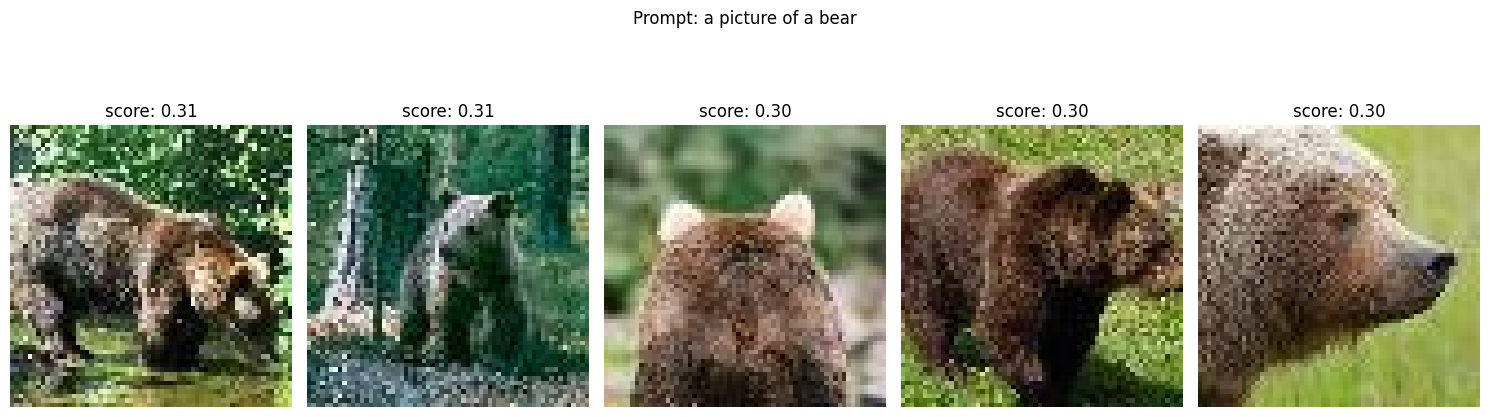

In [ ]:
# Test with text queries
prompts = ["a frog", "a rabbit", "a car", "a horse", "a picture of a bear"]
for prompt in prompts:
    txt_img_res = text_to_image_search(prompt, processor, model, embeddings, dataset.samples, device='cpu', top_k=5)
    visualize_search_results(txt_img_res, prompt)

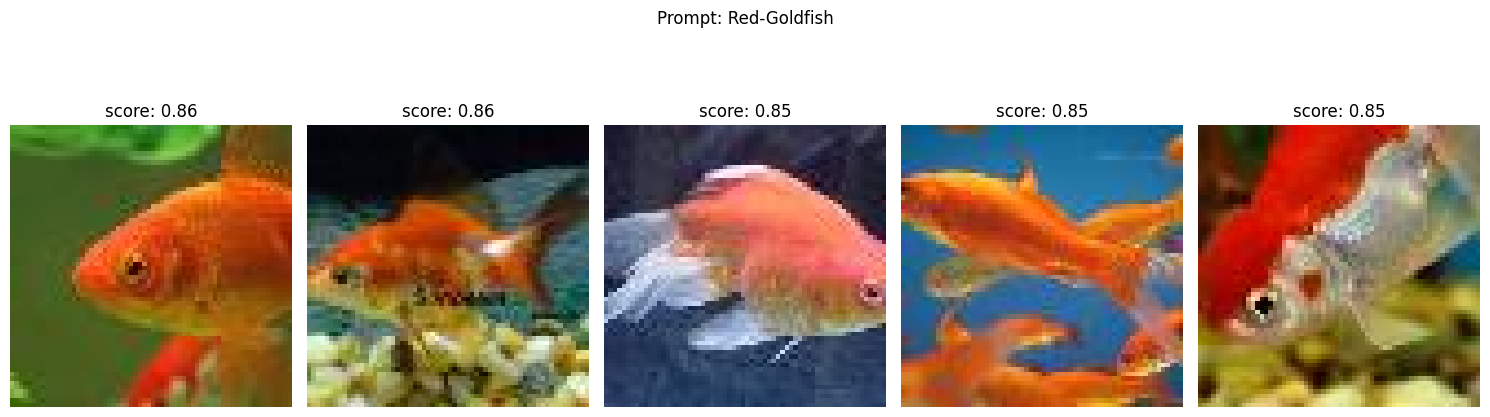

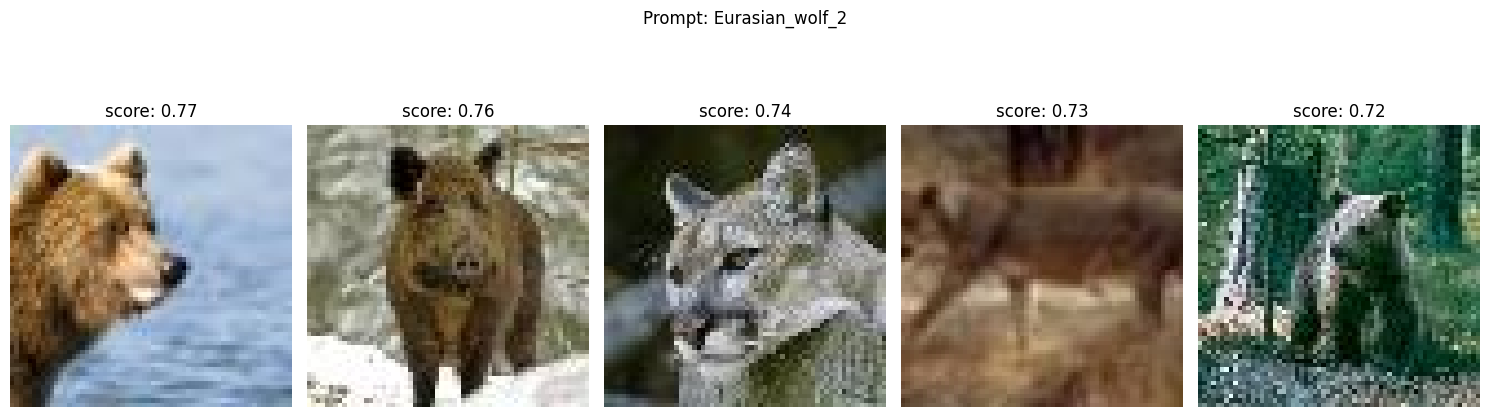

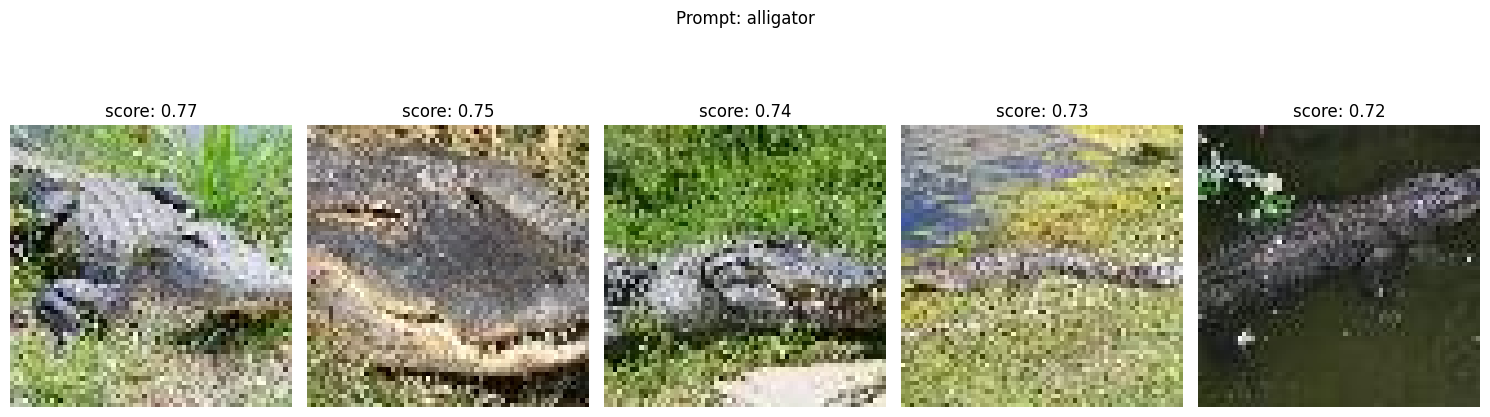

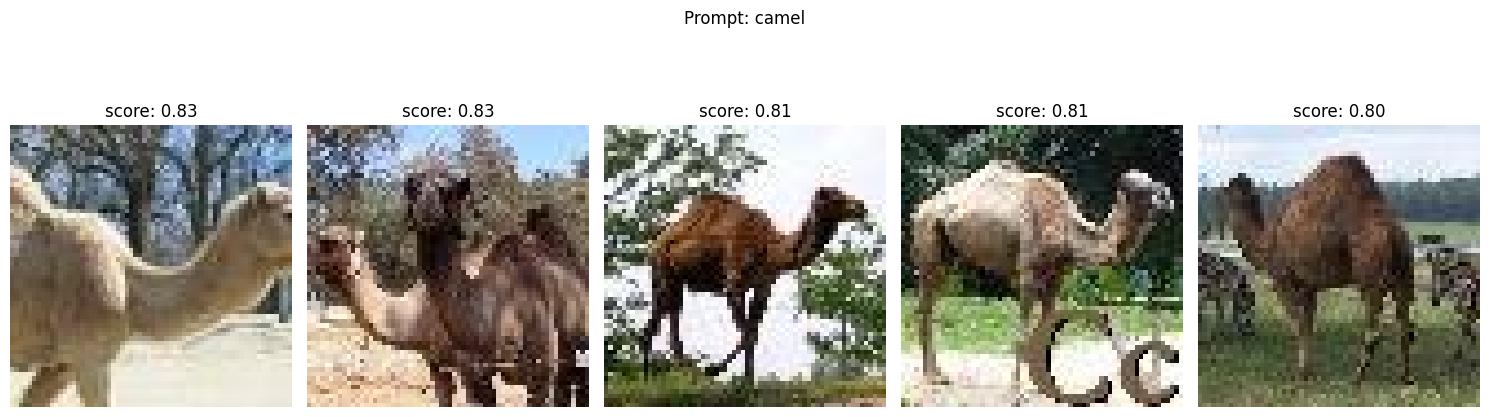

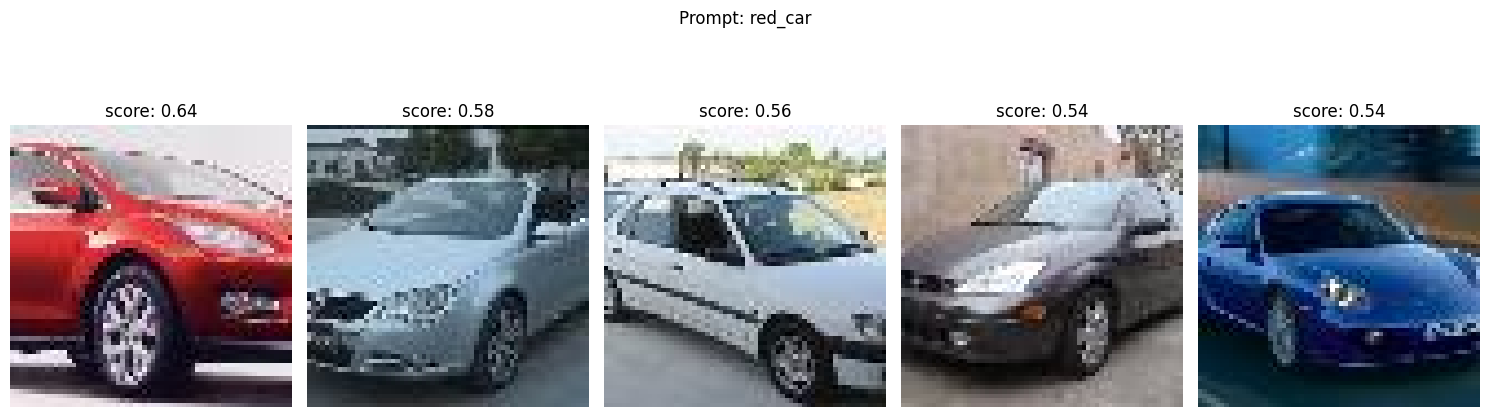

In [ ]:
# Test with image queries from web
# Define image URLs for testing
# URL_goldfish = https://www.squiresgardencentres.co.uk/shop/products/pets-and-aquatics/aquatics/pond-fish/red-goldfish-2-3.html
# URL_wolf = https://en.wikipedia.org/wiki/Wolf
# URL_alligator = https://www.treehugger.com/alligator-facts-5119214
# URL_red_car = https://en.wikipedia.org/wiki/Car
# URL_camel = https://it.wikipedia.org/wiki/Dromedari_selvatici_in_Australia

prompts = ["Red-Goldfish.jpg", "Eurasian_wolf_2.jpg", "alligator.jpg", "camel.jpg", "red_car.jpg"]
for prompt in prompts: # the prompt is an image in this case from the URLs above
    img_img_res = image_to_image_search(prompt, processor, model, embeddings, dataset.samples, device='cpu', top_k=5)
    visualize_search_results(img_img_res, prompt[:-4])